In [1]:
import numpy as np
import cv2
import os
import sys
from skimage import io
from matplotlib import pyplot as plt
# from google.colab.patches import cv2_imshow
from tqdm import tqdm

In [56]:
def plt_imshow(image, figsize=(10, 10)):
    img2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB )
    plt.figure(figsize=figsize)
    plt.imshow(img2)
    plt.show()

In [10]:
def cv2_imshow(image, wname='image'):
    cv2.imshow(wname, image)
    cv2.waitKey()
#     cv2.destroyWindow(wname) #make sure window closes cleanly

In [11]:
def url_to_image(url):
  # print("downloading %s" % (url))
  return cv2.cvtColor(io.imread(url), cv2.COLOR_BGR2RGB)

In [12]:
url_template = "http://www.ee.columbia.edu/~rj2349/index_files/Homework1/ukbench{:05d}.jpg"
image_range = range(0, 2000)

In [13]:
data_path = "ContentBasedDataset/Homework1"
file_names = os.listdir(data_path)
dataset = []
for name in tqdm(file_names):
    dataset.append(cv2.imread(os.path.join(data_path, name), cv2.IMREAD_COLOR))

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 196.36it/s]


In [14]:
# dataset = []
# for image_index in tqdm(image_range):
#   dataset.append(url_to_image(url_template.format(image_index)))

In [15]:
query_indices = [4, 40, 60, 588, 1560]

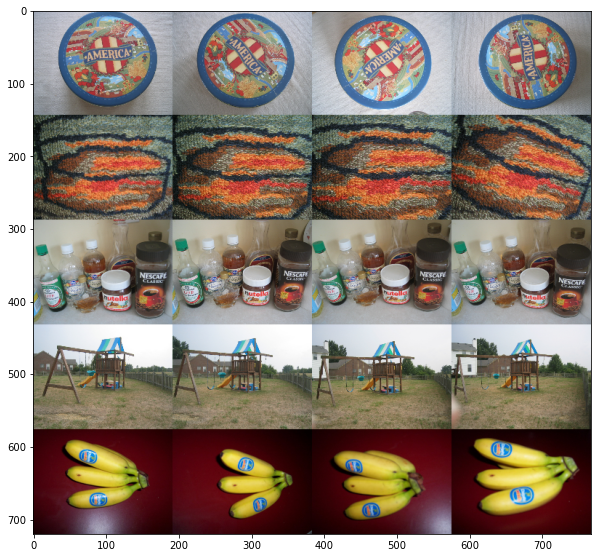

In [16]:
h_stacks = []
for q_index in query_indices:
  similar_images = [dataset[q_index + i] for i in range(4) ]
  h_stacks.append(np.hstack(similar_images))

all_stack = np.vstack(h_stacks)
all_stack = cv2.resize(all_stack, (0,0), fx=0.3, fy=0.3)
plt_imshow(all_stack)
# plt.show()

# Checking dataset guarantees. 

In [17]:
domainDtype = dataset[0].dtype
n_channels = dataset[0].shape[2]
for im in dataset:
  assert(domainDtype == im.dtype)

In [18]:
def GetTypeRange(dtypeVal):
  typeInfo = np.iinfo(dtypeVal)
  return typeInfo.max - typeInfo.min + 1

In [19]:
def MyHisto(srcImage, nBins = 256):
  
  # building histograms for each channel separately
  allChannelsHisto = []
  typeRange = GetTypeRange(srcImage.dtype)
  mapToBin = nBins / GetTypeRange(srcImage.dtype)

  for ch in tqdm(range(srcImage.shape[2])):
    # It is faster to use pixVal as a mapping index and then transform final histo
    # then recompute required bin for each pixel individially
    histo = np.zeros((typeRange), dtype = np.uint32)

    for pixVal in srcImage[:, :, ch].flatten():
      histo[pixVal] += 1

    requiredSizeHisto = np.zeros((nBins), dtype = np.uint32)
    for fullScaleBinIndex, binN in enumerate(histo):
      binIndex = fullScaleBinIndex * nBins // GetTypeRange(srcImage.dtype)
      requiredSizeHisto[binIndex] += binN

    allChannelsHisto.append(requiredSizeHisto)

  return np.hstack(allChannelsHisto)

In [309]:
def NpHisto(srcImage, nBins = 256):
    if len(srcImage.shape) > 2:
        return np.hstack([np.histogram(srcImage[:, :, ch], nBins, range=(0, nBins-1))[0]
            for ch in range(srcImage.shape[2])])
    else:
        return np.histogram(srcImage, nBins, range=(0, nBins-1))[0]

In [21]:
def CvHisto(srcImage, nBins = 256):
  dtypeInfo = np.iinfo(srcImage.dtype)
  return np.hstack([np.int32(cv2.calcHist([img],[0],None,[nBins],[dtypeInfo.min,dtypeInfo.max+1]).flatten()),
                   np.int32(cv2.calcHist([img],[1],None,[nBins],[dtypeInfo.min,dtypeInfo.max+1]).flatten()),
                   np.int32(cv2.calcHist([img],[2],None,[nBins],[dtypeInfo.min,dtypeInfo.max+1]).flatten())])

## Implementation of openCV works in predictable way, yet having rather strange interface. It corresponds to our implementation for arbitrary number of bins requested.

In [22]:
img = dataset[0]
assert(np.all(MyHisto(img, 256) == CvHisto(img, 256)))
assert(np.all(MyHisto(img, 100) == CvHisto(img, 100)))


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.47it/s]


## Numpy uses nontrivial mappings to bin indices if number of bins is different from image domain range, so we have difference in those cases.
## For full value domain mapping we have no issues (256 mapped ok)

In [23]:
img = dataset[0]
assert(np.all(MyHisto(img, 256) == NpHisto(img, 256)))
np.all(MyHisto(img, 100) == NpHisto(img, 100)) # Mapping here is non-trivial

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.41it/s]


False

# There is a nice tooling in np.histogram API for adaptive histogram size computation.
# Issue that we have to call it separately for each channel and disable range transformation (which distorts color distribution)

In [24]:
def L2ForHistoNP(h1, h2):
  return np.linalg.norm(h1 - h2)

def L2ForHistoMy(h1, h2):
  diff = np.float64(h1 - h2)
  distance = [d * d for d in diff]
  return np.sqrt(sum(distance))

In [25]:
histos = [MyHisto(dataset[i]) for i in range(3)]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.44it/s]


In [26]:
assert (L2ForHistoNP(histos[0], histos[0]) == L2ForHistoMy(histos[0], histos[0]))
assert (abs(L2ForHistoNP(histos[1], histos[2]) - L2ForHistoMy(histos[1], histos[2])) < 1e-3)

# Summary:
## Our L2 distance exactly matches **numpy** version results.

In [402]:
def DisplayBestImages(images):
   disp_images = []
   for dispMatch in images:

    # Handling images rotated 90 deg to display it with np.hstack
    if dispMatch.shape != images[0].shape:
      dispMatch = np.rot90(dispMatch,axes=(0,1))
    disp_images.append(dispMatch)
    
   plt_imshow(np.hstack(disp_images), figsize=(20, 10))

def GetBestMatchForQuery(q_image_index):
  index_to_distance = []
  q_histo = histos[q_image_index]
  for index, histo in enumerate(histos):
    index_to_distance.append((index, L2ForHistoNP(q_histo, histo)))
    # As we use normalized histograms, cosine similarity acts the same as L2 distance
#     index_to_distance.append((index, spatial.distance.cosine(q_histo, histo)))
  index_to_distance = sorted(index_to_distance, key=lambda x: x[1])
  best10 = [dataset[match[0]] for match in index_to_distance[:10]]
  print(index_to_distance[:10])
  return index_to_distance[:10]

In [80]:
def PlotPRCurve(ps, rs, title='Precision-Recall Case'):
  plt.plot(rs, ps, 'b.-');
  plt.xlabel('Recall');
  plt.ylabel('Precision');
  plt.title(title);
  plt.axis([0.2, 1.05, -0.2, 1.1]); # Adjust axes for better viewing
  plt.grid();  
  plt.show()

In [81]:
def MeasurePR(q_index, resultingValues):
  correct_predictions = [q_index + i for i in range(4)]
  relevant_results_indices_sorted = []
  
  for result_index, pred in enumerate(resultingValues):
    if pred in correct_predictions:
      relevant_results_indices_sorted.append(result_index)

  # Add missing true_positives as elements with inf index.
  while not len(relevant_results_indices_sorted) == 4:
    relevant_results_indices_sorted.append(np.inf)

  relevant_indices_as_positions = np.array(range(1, len(relevant_results_indices_sorted)+1))
  perfect_result_positions = (np.array(relevant_results_indices_sorted)+1)

  precision = relevant_indices_as_positions / perfect_result_positions
  recall = relevant_indices_as_positions / 4

  return precision, recall

### We are using HSV images here, as color-based comparison here has more sense then in RGB. Also separated information about luminance of the color allows us to drop (significantly reduce) the influence of lightening difference.

In [84]:
hsv_images = [ cv2.cvtColor(im, cv2.COLOR_BGR2HSV) for im in dataset ]

In [87]:
EPS = np.finfo(np.float32).eps

## *Since exact reproduction is confirmed, we are using **numpy** version as it much faster then what could be implemented using bare python code.*

In [405]:
histos = []
for i, im in enumerate(tqdm(hsv_images)):
  histo = NpHisto(im[:, :, :-1], 100)
  histos.append(histo / (np.sum(histo)+EPS) )

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 146.40it/s]


In [406]:
mean_histo = np.mean(histos, axis=0)
histos = [h / mean_histo for h in histos]
histos = [h / (np.sum(h)+EPS) for h in histos]

### Dividing of resulting histograms in dataset on a mean one gives very significant improvement.
### As we have histogram normed to 1, they act like probabilities. Here we replace simple observation with conditional one.
### Where conditioning critetion is distribution in dataset. If some pixel value is common in dataset, peak on its values are smoothened, as they give less important info and more noise. While rare pixel values will be divided by smaller number, thus increase in magnitude to its express significance.

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

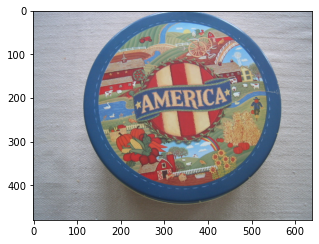

[(4, 0.0), (7, 0.019778826206741956), (5, 0.020087475290347157), (6, 0.03529624053403538), (819, 0.04476974327133934), (14, 0.04531588585021926), (1999, 0.04787032746926553), (887, 0.04816560433221209), (884, 0.04844649893078295), (1998, 0.04923243119991564)]


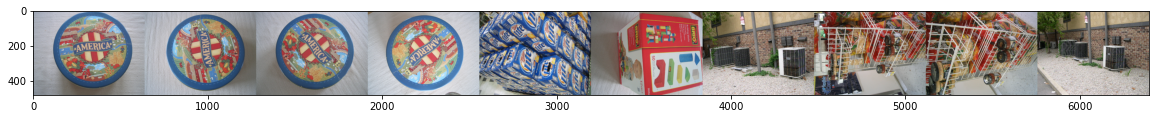

 20%|████████████████▊                                                                   | 1/5 [00:00<00:02,  1.87it/s]

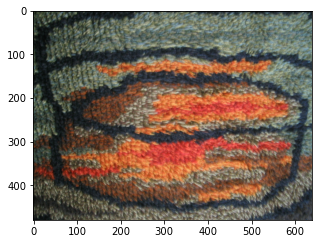

[(40, 0.0), (42, 0.02318762802913261), (41, 0.0234803468245634), (43, 0.029845767507837857), (808, 0.05134438968631988), (1483, 0.05656362385128858), (1681, 0.05793130508226767), (704, 0.05873585676271862), (809, 0.05930985185875924), (869, 0.05947942617965623)]


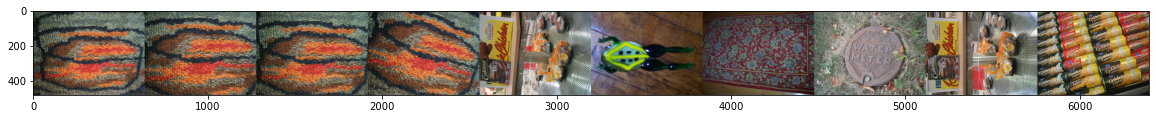

 40%|█████████████████████████████████▌                                                  | 2/5 [00:01<00:01,  1.84it/s]

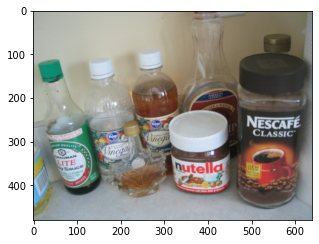

[(60, 0.0), (63, 0.031952456276526466), (61, 0.035419518945159885), (84, 0.03911377363542097), (811, 0.03968071504194536), (87, 0.040790196731746026), (86, 0.041186785470586185), (812, 0.041236480999902625), (62, 0.04207086296180149), (813, 0.04212575438824392)]


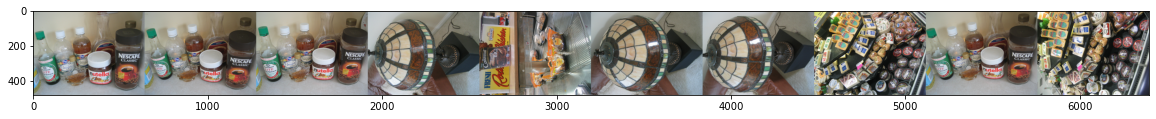

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:01<00:01,  1.83it/s]

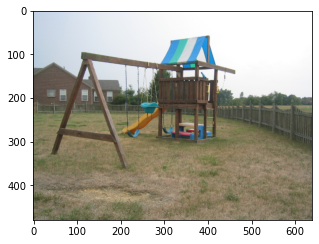

[(588, 0.0), (589, 0.019407452294006512), (1610, 0.05987094002646527), (1602, 0.062148620504612416), (1601, 0.062495454552906615), (591, 0.06315565069563815), (1971, 0.06445719555537104), (1600, 0.06492698148395007), (217, 0.06498560383685888), (842, 0.06580323299934142)]


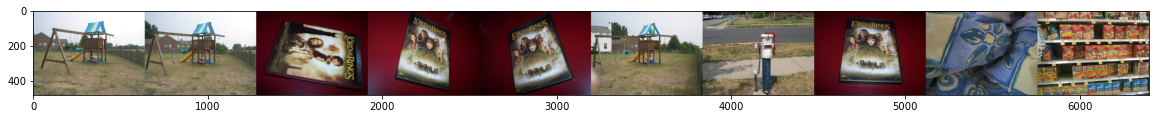

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:02<00:00,  1.82it/s]

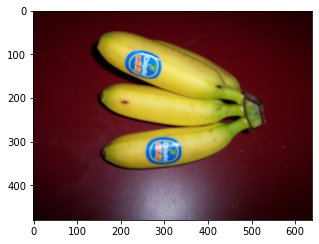

[(1560, 0.0), (1561, 0.09444756984387886), (1563, 0.09678409490806701), (1562, 0.10982681588671664), (797, 0.11273883137449105), (1725, 0.1297755860351844), (796, 0.13058942743703597), (1724, 0.13175556551159254), (800, 0.13390861414606156), (799, 0.1355907537145692)]


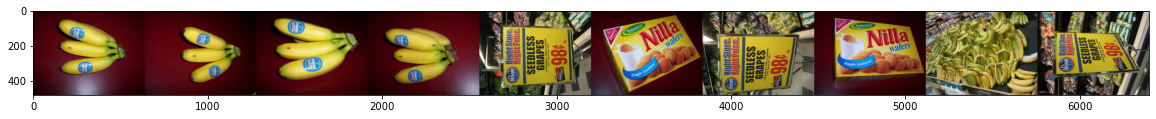

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


In [407]:
q_results = []
for q_im_index in tqdm(query_indices):
  
  q_im = dataset[q_im_index]
  plt_imshow(q_im, (5, 5))
  
  index_to_distance = GetBestMatchForQuery(q_im_index)
  resulting_images = [dataset[match[0]] for match in index_to_distance[:10]]
  DisplayBestImages(resulting_images)

  q_results.append(index_to_distance)

In [399]:
q_results_indices = [ [el[0] for el in q_case]for q_case in q_results]

In [400]:
q_results_indices

[[4, 7, 5, 6, 14, 819, 887, 1628, 884, 1999],
 [40, 42, 41, 43, 1681, 808, 1483, 869, 1682, 704],
 [60, 63, 61, 84, 811, 87, 86, 62, 812, 292],
 [588, 589, 1610, 669, 591, 1602, 1971, 1609, 1601, 569],
 [1560, 1563, 1561, 797, 1562, 802, 796, 799, 798, 1856]]

[1. 1. 1. 1.]
[0.25 0.5  0.75 1.  ]


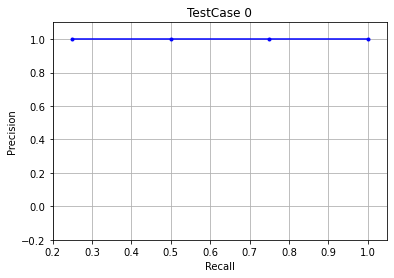

[1. 1. 1. 1.]
[0.25 0.5  0.75 1.  ]


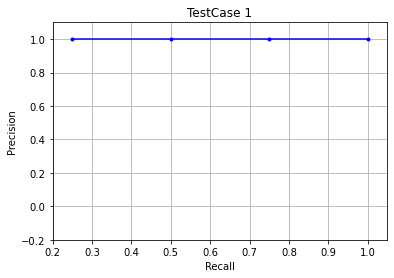

[1.  1.  1.  0.5]
[0.25 0.5  0.75 1.  ]


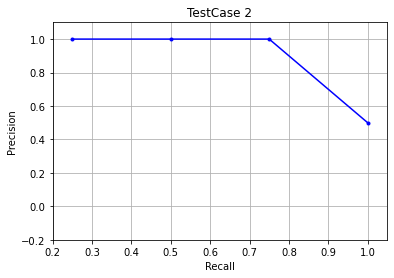

[1.  1.  0.6 0. ]
[0.25 0.5  0.75 1.  ]


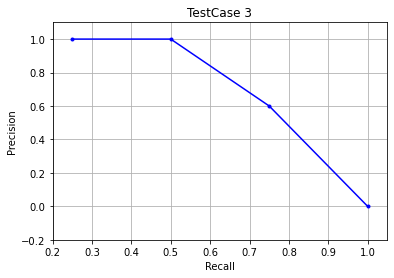

[1.  1.  1.  0.8]
[0.25 0.5  0.75 1.  ]


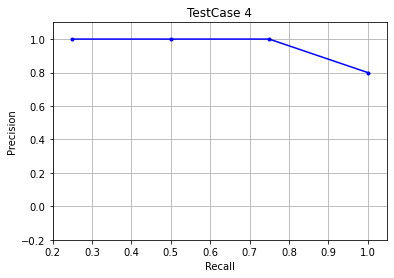

In [401]:
# Size of histogram dereesed from 255 to 100 (only)
for test_case_index, q_index in enumerate(query_indices):
  ps = []
  rs = []
  query_results = q_results_indices[test_case_index]
  
  ps, rs = MeasurePR(q_index, query_results)
  print(ps)
  print(rs)

  PlotPRCurve(ps, rs, "TestCase {}".format(test_case_index))

[1.         1.         1.         0.66666667]
[0.25 0.5  0.75 1.  ]


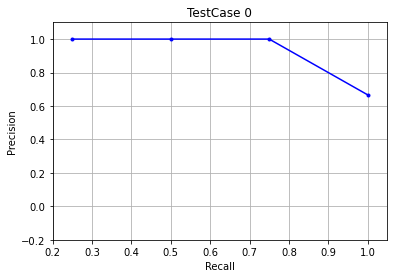

[1. 1. 1. 1.]
[0.25 0.5  0.75 1.  ]


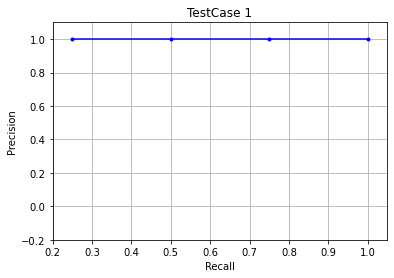

[1.         0.66666667 0.6        0.        ]
[0.25 0.5  0.75 1.  ]


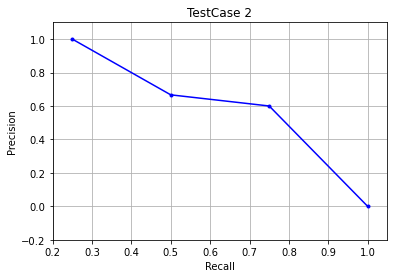

[1. 1. 0. 0.]
[0.25 0.5  0.75 1.  ]


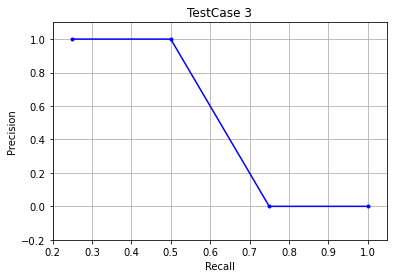

[1. 1. 0. 0.]
[0.25 0.5  0.75 1.  ]


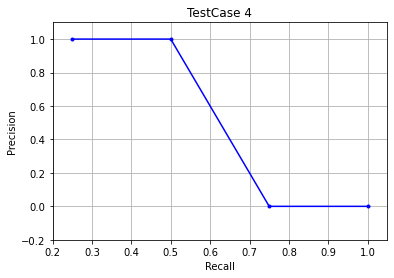

In [355]:
# Basic version
for test_case_index, q_index in enumerate(query_indices):
  ps = []
  rs = []
  query_results = q_results_indices[test_case_index]
  
  ps, rs = MeasurePR(q_index, query_results)
  print(ps)
  print(rs)

  PlotPRCurve(ps, rs, "TestCase {}".format(test_case_index))

## As we observe, for some samples precision is good (test case 1): we've found all elements sorted at primary positions. For other cases we found only the queried element itself, what is trivial, but says nothing good about robustness of our metric.

## "banana" case is a total failure, for the basic version as we have lots of similar images in dataset with similar background, but different object of interest.